In [36]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

In [37]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Statistical analysis
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

In [39]:
# Machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [40]:
# Preprocessing
from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder

In [41]:
# Timing
import time
import datetime as dt

In [42]:
# Serialization
import pickle
import json

In [43]:
# disable warnings
import warnings
warnings.filterwarnings('ignore') #turn off warning

In [44]:
# Deep learning libraries
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.models import Sequential, Model # architecture
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate # layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# 1. Read

In [45]:
df_no = pd.read_csv("data_clustered.csv", index_col=False)
df_all = pd.read_csv("data_cleaned.csv", index_col=False)
df_yes = df_all[df_all['response'] == 1]
df_yes['response'] = 3
df_no['response'] = df_no['Cluster_Labels']
df_yes['Cluster_Labels'] = -1
# Create new features from amount features
df_yes["total_mnt"] = df_yes["mnt_wines"] + df_yes["mnt_fruits"] + df_yes["mnt_meat_products"] + df_yes["mnt_fish_products"] + df_yes["mnt_sweet_products"] + df_yes["mnt_gold_prods"]
# Filter out rows where year_birth is less than 1928
df_yes = df_yes[df_yes["year_birth"] >= 1928]

# Define generation labels and ranges
generations = {
    "Silent Generation": (1928, 1945),
    "Baby Boomers": (1946, 1964),
    "Generation X": (1965, 1980),
    "Millennials": (1981, 1996)
}

# Create a function to assign generation label
def assign_generation(year):
    for gen, (start, end) in generations.items():
        if start <= year <= end:
            return gen

# Apply the function to the year_birth feature
df_yes["generation"] = df_yes["year_birth"].apply(assign_generation)
df_yes["dt_customer"] = pd.to_datetime(df_yes["dt_customer"], format="%d-%m-%Y")

# Create new features from date features
df_yes["customer_since"] = (dt.datetime(2015, 1, 1) - df_yes["dt_customer"]).dt.days
# Drop unnecessary columns
df_yes = df_yes.drop(["Unnamed: 0", "id", "dt_customer"], axis=1) ## these columns won't help the model
df = pd.concat([df_no, df_yes], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year_birth             2205 non-null   int64  
 1   education              2205 non-null   object 
 2   marital_status         2205 non-null   object 
 3   income                 2205 non-null   float64
 4   kidhome                2205 non-null   int64  
 5   teenhome               2205 non-null   int64  
 6   recency                2205 non-null   int64  
 7   mnt_wines              2205 non-null   int64  
 8   mnt_fruits             2205 non-null   int64  
 9   mnt_meat_products      2205 non-null   int64  
 10  mnt_fish_products      2205 non-null   int64  
 11  mnt_sweet_products     2205 non-null   int64  
 12  mnt_gold_prods         2205 non-null   int64  
 13  num_deals_purchases    2205 non-null   int64  
 14  num_web_purchases      2205 non-null   int64  
 15  num_

In [46]:
# Define the list of numerical columns
num_col = ['year_birth', 'income', 'kidhome', 'teenhome','recency','mnt_wines','mnt_fruits',
        'mnt_meat_products','mnt_fish_products','mnt_sweet_products','mnt_gold_prods',
        'num_deals_purchases','num_web_purchases','num_catalog_purchases',
        'num_store_purchases','num_web_visits_month', "total_mnt", "customer_since"]

# Create a new DataFrame
cor_num = pd.DataFrame(index=num_col, columns=["corr", "pval", "has_relation"])

# Loop through the numerical columns
for col in num_col:
    # Calculate the Kendall's tau correlation
    corr_tau, pval_k = st.kendalltau(df[col], df['response'])
    # Set the values in the DataFrame
    cor_num.loc[col, "corr"] = corr_tau
    cor_num.loc[col, "pval"] = pval_k
    cor_num.loc[col, "has_relation"] = pval_k < 0.05

In [47]:
cor_num

,corr,pval,has_relation
year_birth,-0.084594,0.0,True
income,0.553872,0.0,True
kidhome,-0.430432,0.0,True
teenhome,-0.112761,0.0,True
recency,-0.086192,0.0,True
mnt_wines,0.540171,0.0,True
mnt_fruits,0.444975,0.0,True
mnt_meat_products,0.607979,0.0,True
mnt_fish_products,0.444868,0.0,True
mnt_sweet_products,0.431857,0.0,True


In [48]:
# Define the list of categorical columns
cat_col = ['education','marital_status',
        'accepted_cmp1','accepted_cmp2','accepted_cmp3',
        'accepted_cmp4','accepted_cmp5','complain', 'generation']

# Create a new DataFrame for categorical correlations
cor_cat = pd.DataFrame(index=cat_col, columns=["pval", "has_relation"])

# Loop through the categorical columns
for col in cat_col:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['response'])
    
    # Calculate the chi-square test
    chi2, pval, _, _ = st.chi2_contingency(contingency_table)
    
    # Set the values in the DataFrame
    cor_cat.loc[col, "pval"] = pval
    cor_cat.loc[col, "has_relation"] = pval < 0.05

In [49]:
cor_cat

,pval,has_relation
education,0.0,True
marital_status,0.0,True
accepted_cmp1,0.0,True
accepted_cmp2,0.0,True
accepted_cmp3,0.0,True
accepted_cmp4,0.0,True
accepted_cmp5,0.0,True
complain,0.90874,False
generation,0.0,True


In [50]:
# Numerical columns
num_col = cor_num[(cor_num['has_relation'] == True) & ((cor_num['corr'] >= 0.1) | (cor_num['corr'] <= -0.1))].index.tolist()


# Categorical columns
cat_col = cor_cat[cor_cat['has_relation'] == True].index.tolist()

# Combine the lists
col_to_keep = num_col + cat_col
col_to_keep

['income',
 'kidhome',
 'teenhome',
 'mnt_wines',
 'mnt_fruits',
 'mnt_meat_products',
 'mnt_fish_products',
 'mnt_sweet_products',
 'mnt_gold_prods',
 'num_web_purchases',
 'num_catalog_purchases',
 'num_store_purchases',
 'num_web_visits_month',
 'total_mnt',
 'customer_since',
 'education',
 'marital_status',
 'accepted_cmp1',
 'accepted_cmp2',
 'accepted_cmp3',
 'accepted_cmp4',
 'accepted_cmp5',
 'generation']

# 2. Split

In [51]:
# separate X and y
X = df
y = df['response']

In [52]:
y.value_counts()

response
0    935
1    523
2    414
4    333
Name: count, dtype: int64

very imbalanced.

In [53]:
# split data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=77)

print('Train Size :', X_train.shape)
print('Test Size :', X_test.shape)
print('Train Size :', y_train.shape)
print('Test Size :', y_test.shape) 

Train Size : (1477, 29)
Test Size : (728, 29)
Train Size : (1477,)
Test Size : (728,)


In [54]:
# split based on data type
X_train_cat = X_train[cat_col]
X_train_num = X_train[num_col]
X_test_cat = X_test[cat_col]
X_test_num = X_test[num_col]

## 4. Outlier Handling

Outliers or extreme values can affect the mean of the data by very significantly, as some models are not robust towards outliers. Before detecting the outliers, we need to know the skewness of each columns to decide the method to use to identify outliers, as each type have very different distributions.

In [55]:
# menggunakan lambda, calculate skewness for each column
skewness = X_train_num.apply(lambda x: st.skew(x))

# Separate columns into skewed and normal based on the threshold (0.5)
col_s = skewness[abs(skewness) > 0.5].index.tolist()
col_n = skewness[abs(skewness) <= 0.5].index.tolist()

# print separated columns
print("Skewed Columns:", col_s)
print("Normal Columns:", col_n)

Skewed Columns: ['kidhome', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'total_mnt']
Normal Columns: ['income', 'teenhome', 'num_web_visits_month', 'customer_since']


### 4.1. Normal Columns

In [56]:
def calculate_zscores(data_frame, column_name):
    """
    Calculate z-scores for a specific column in a DataFrame.
    """
    # Calculate mean and standard deviation
    mean_value = data_frame[column_name].mean()
    std_dev = data_frame[column_name].std()

    # Calculate z-scores
    z_scores = (data_frame[column_name] - mean_value) / std_dev

    return z_scores

In [57]:
def outliers_percentage_zscore(data_frame, column_name):
    """
    Identify outliers in a specified column of a DataFrame using z-scores,
    calculate the percentage, and print the result.
    """
    # Calculate z-scores
    z_scores = calculate_zscores(data_frame, column_name)

    # Identify outliers based on z-scores
    outliers = data_frame[abs(z_scores) > 3]

    # Calculate percentage of outliers
    percentage_outliers = (len(outliers) / len(data_frame)) * 100

    # Print the result
    print(f'Column: {column_name}')
    print(f'Percentage of outliers: {percentage_outliers:.2f}%')

In [58]:
# Loop through each feature
for feature in col_n:
    # Call the function
    outliers_percentage_zscore(X_train_num, feature)

Column: income
Percentage of outliers: 0.00%
Column: teenhome
Percentage of outliers: 0.00%
Column: num_web_visits_month
Percentage of outliers: 0.47%
Column: customer_since
Percentage of outliers: 0.00%


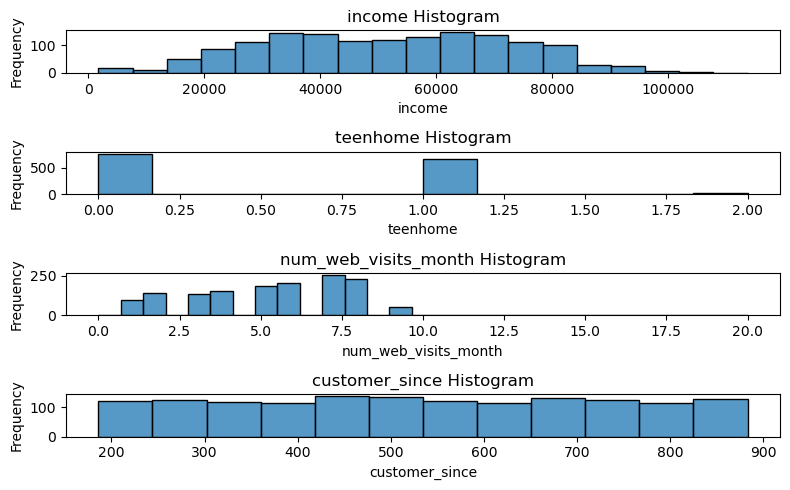

In [59]:
# Get the number of columns
n_cols = len(col_n)

# Create a figure and axes object
fig, axes = plt.subplots(nrows=n_cols, ncols=1, figsize=(8, 5))

# Loop over the columns and plot a histogram for each column
for i, col in enumerate(col_n):
    # Plot the histogram using seaborn
    sns.histplot(data=X_train_num, x=col, ax=axes[i])
    # Set the title and labels
    axes[i].set_title(col + " Histogram")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

I'm removing outliers in income.

In [60]:
def remove_outliers_zscore(data_frame, column_name, z_threshold=3):
    """
    Remove outliers from a specified column of a DataFrame using z-scores.
    """
    # Calculate z-scores
    z_scores = calculate_zscores(data_frame, column_name)

    # Identify outliers based on z-scores
    outliers = data_frame[abs(z_scores) > z_threshold]

    # Remove outliers from the DataFrame
    data_frame_no_outliers = data_frame[abs(z_scores) <= z_threshold]

    return data_frame_no_outliers

X_train_num = remove_outliers_zscore(X_train_num, 'income')
y_train = y_train.loc[X_train_num.index]
X_train_cat = X_train_cat.loc[X_train_num.index]

### 4.2. Skewed Columns

In [61]:
def calculate_iqr(data_frame, column_name):
    """
    Calculate the Interquartile Range (IQR) for a specific column in a DataFrame.
    """

    # Calculate quartiles
    Q1 = data_frame[column_name].quantile(0.25)
    Q3 = data_frame[column_name].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [62]:
def outliers_percentage(data_frame, column_name):
    """
    Identify outliers in a specified column of a DataFrame, calculate the percentage,
    and print the result along with upper and lower boundaries.
    """
    # Calculate IQR
    lower_bound, upper_bound = calculate_iqr(data_frame, column_name)

    # Identify outliers
    outliers = data_frame[(data_frame[column_name] < lower_bound) | (data_frame[column_name] > upper_bound)]

    # Calculate percentage of outliers
    percentage_outliers = (len(outliers) / len(data_frame)) * 100

    # Print the result
    print(f'Column: {column_name}')
    print(f'Lower Boundary: {lower_bound:.2f}')
    print(f'Upper Boundary: {upper_bound:.2f}')
    print(f'Percentage of outliers: {percentage_outliers:.2f}%')

In [63]:
# Loop through each feature
for feature in col_s:
    # Call the function
    outliers_percentage(X_train_num, feature)

Column: kidhome
Lower Boundary: -1.50
Upper Boundary: 2.50
Percentage of outliers: 0.00%
Column: mnt_wines
Lower Boundary: -712.50
Upper Boundary: 1251.50
Percentage of outliers: 1.56%
Column: mnt_fruits
Lower Boundary: -46.00
Upper Boundary: 82.00
Percentage of outliers: 10.09%
Column: mnt_meat_products
Lower Boundary: -317.00
Upper Boundary: 571.00
Percentage of outliers: 7.38%
Column: mnt_fish_products
Lower Boundary: -67.50
Upper Boundary: 120.50
Percentage of outliers: 10.83%
Column: mnt_sweet_products
Lower Boundary: -50.00
Upper Boundary: 86.00
Percentage of outliers: 10.29%
Column: mnt_gold_prods
Lower Boundary: -63.00
Upper Boundary: 129.00
Percentage of outliers: 9.28%
Column: num_web_purchases
Lower Boundary: -4.00
Upper Boundary: 12.00
Percentage of outliers: 0.14%
Column: num_catalog_purchases
Lower Boundary: -6.00
Upper Boundary: 10.00
Percentage of outliers: 0.81%
Column: num_store_purchases
Lower Boundary: -4.50
Upper Boundary: 15.50
Percentage of outliers: 0.00%
Column

## 5. Feature Scaling

In [64]:
scaler_n = StandardScaler()
scaler_n.fit(X_train_num)

StandardScaler()

In [65]:
X_train_num_scaled = scaler_n.transform(X_train_num)
X_test_num_scaled = scaler_n.transform(X_test_num)

## 6. Feature Encoding

In [66]:
for col in X_train_cat.columns:
    print(col)
    print(X_train_cat[col].unique())

education
['Graduation' '2n Cycle' 'Master' 'PhD' 'Basic']
marital_status
['Together' 'Married' 'Divorced' 'Single' 'Widow' 'YOLO' 'Absurd' 'Alone']
accepted_cmp1
[0 1]
accepted_cmp2
[0 1]
accepted_cmp3
[0 1]
accepted_cmp4
[0 1]
accepted_cmp5
[0 1]
generation
['Generation X' 'Baby Boomers' 'Millennials' 'Silent Generation']


In [67]:
def encoder(df):
    # Define the mappings for each variable
    education_mapping = {'PhD': 0, 'Basic': 1, 'Graduation': 2, 'Master': 3, '2n Cycle': 4}
    marital_status_mapping = {'Together': 0, 'Married': 1, 'Single': 2, 'Divorced': 3, 'Widow': 4, 'Alone': 5, 'YOLO': 6, 'Absurd': 7}
    accepted_cmp_mapping = {0: 0, 1: 1}
    generation_mapping = {'Silent Generation':0, 'Baby Boomers': 1, 'Millennials': 2, 'Generation X': 3}

    # Apply the mappings to the DataFrame
    df['education'] = df['education'].map(education_mapping)
    df['marital_status'] = df['marital_status'].map(marital_status_mapping)
    df['accepted_cmp1'] = df['accepted_cmp1'].map(accepted_cmp_mapping)
    df['accepted_cmp2'] = df['accepted_cmp2'].map(accepted_cmp_mapping)
    df['accepted_cmp3'] = df['accepted_cmp3'].map(accepted_cmp_mapping)
    df['accepted_cmp4'] = df['accepted_cmp4'].map(accepted_cmp_mapping)
    df['accepted_cmp5'] = df['accepted_cmp5'].map(accepted_cmp_mapping)
    df['generation'] = df['generation'].map(generation_mapping)

    return df

# Apply the function to the training and test data
X_train_cat = encoder(X_train_cat)
X_test_cat = encoder(X_test_cat)

## 7. Concat Data

In [68]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat],axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat],axis=1)

## 8. Oversampling

In [69]:
from imblearn.over_sampling import SVMSMOTE

svmsmote = SVMSMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = svmsmote.fit_resample(X_train_final, y_train)
y_train_balanced.value_counts()

response
0    626
1    626
2    626
4    626
Name: count, dtype: int64

In [70]:
X_train_final = X_train_balanced
y_train = y_train_balanced

# V. Model Definiton and Training

In [73]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)

    print("Classification Report for Training Data:")
    print(classification_report(y_train, y_train_pred))

    y_test_pred = model.predict(X_test)

    print("Classification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))

    print("Confusion Matrix for Test Data:")
    print(confusion_matrix(y_test, y_test_pred))

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(ExtraTreesClassifier())

# Train the model
model.fit(X_train_final, y_train)

OneVsRestClassifier(estimator=ExtraTreesClassifier())

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       626
           1       1.00      0.99      1.00       626
           2       1.00      1.00      1.00       626
           4       0.99      1.00      0.99       626

    accuracy                           1.00      2504
   macro avg       1.00      1.00      1.00      2504
weighted avg       1.00      1.00      1.00      2504

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       309
           1       0.84      0.91      0.87       172
           2       0.83      0.93      0.88       137
           4       0.70      0.38      0.49       110

    accuracy                           0.86       728
   macro avg       0.82      0.80      0.79       728
weighted avg       0.84      0.86      0.84       728

Confusion Matrix for Test Data:
[[297   9   0   3]
 

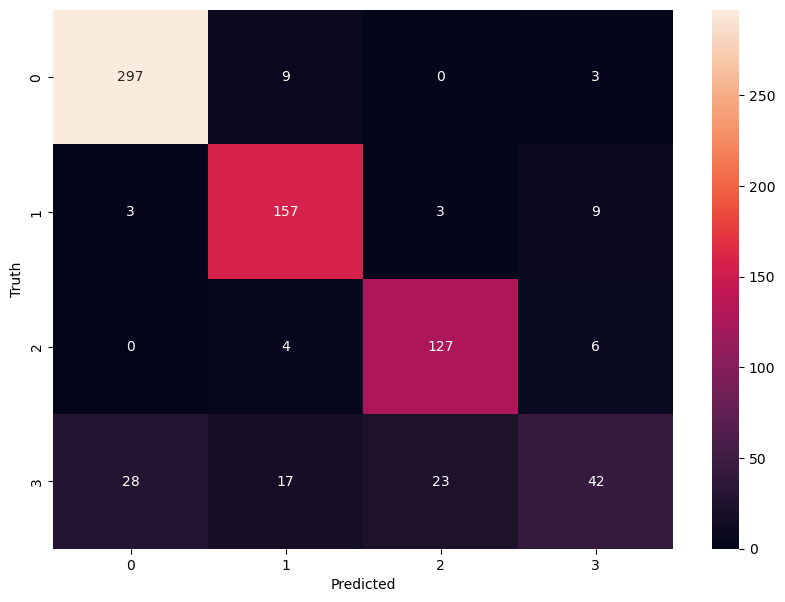

In [77]:
evaluate_model(model, X_train_final, y_train, X_test_final, y_test)